In [1]:
############# NOTEBOOK PARAMETERS ##############

parameters = dict()
parameters['file'] = None # set to None for file prompt
parameters['dynamic_range'] = 40
parameters['interpolation'] = 'bilinear'
parameters['cmap'] = 'viridis'

################################################

from notebook_functions import *


## FUNCTIONS ##

def load_data(file):
    
    with closing(sql.connect(file)) as con:
        
        q = 'SELECT angle, error_type, x, y, z, brightness FROM image ORDER BY angle, x, y, z'
        table = pd.read_sql(q, con)
        
    angles = np.unique(np.array(table['angle']))
    field_pos = np.array(table.loc[table['error_type'] == 'plus', ['x', 'y', 'z']])
    plus_brightness = np.array(table.loc[table['error_type'] == 'plus', 'brightness'])
    minus_brightness = np.array(table.loc[table['error_type'] == 'minus', 'brightness'])
    
    x, y, z = field_pos.T
    nangle = len(angles)
    nx = len(np.unique(x))
    ny = len(np.unique(y))
    nz = len(np.unique(z))
    
    field_pos = field_pos.reshape((nangle, nx, ny, nz, -1))
    plus_brightness = plus_brightness.reshape((nangle, nx, ny, nz))
    minus_brightness = minus_brightness.reshape((nangle, nx, ny, nz))
    
    return plus_brightness, minus_brightness, angles, field_pos


## LOAD DATA ##

if parameters['file'] is None:
    parameters['file'] = open_file_dialog()

file = parameters['file']
dynamic_range = parameters['dynamic_range']
cmap = parameters['cmap']
interpolation = parameters['interpolation']

plus_brightness, minus_brightness, angles, field_pos = load_data(file)
x, y, z = field_pos.T

### <center>Notebook parameters</center>

In [2]:
display(HTML('<center>' + tabulate.tabulate(parameters.items(), tablefmt='html') + '</center>'))

file,D:/Data/foldable linear array/beamplot_xy.db
dynamic_range,40
interpolation,bilinear
cmap,viridis


### <center>Beamplots</center>

Button(description='Export figures', style=ButtonStyle())

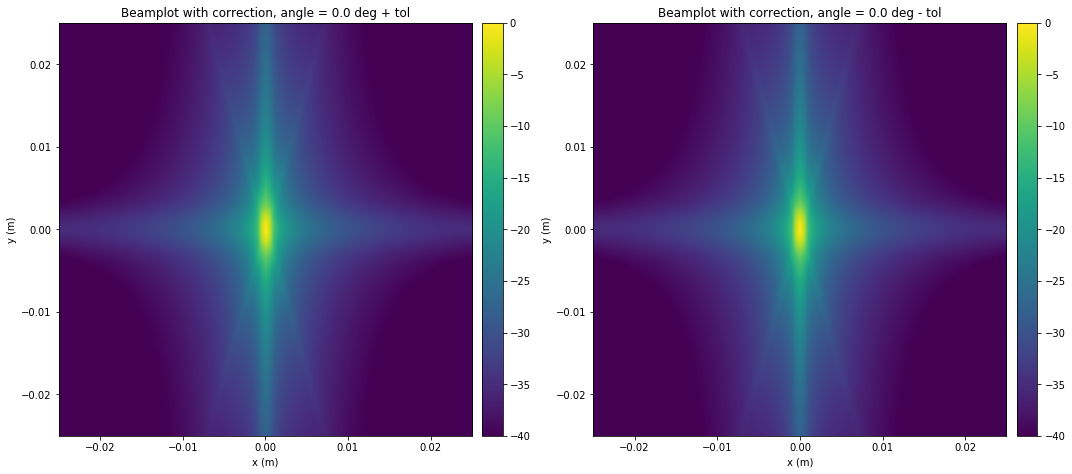

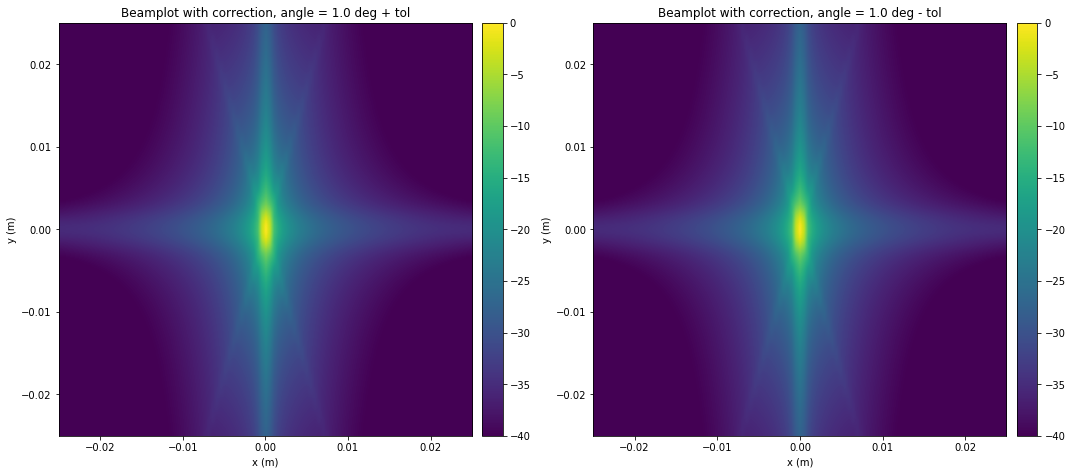

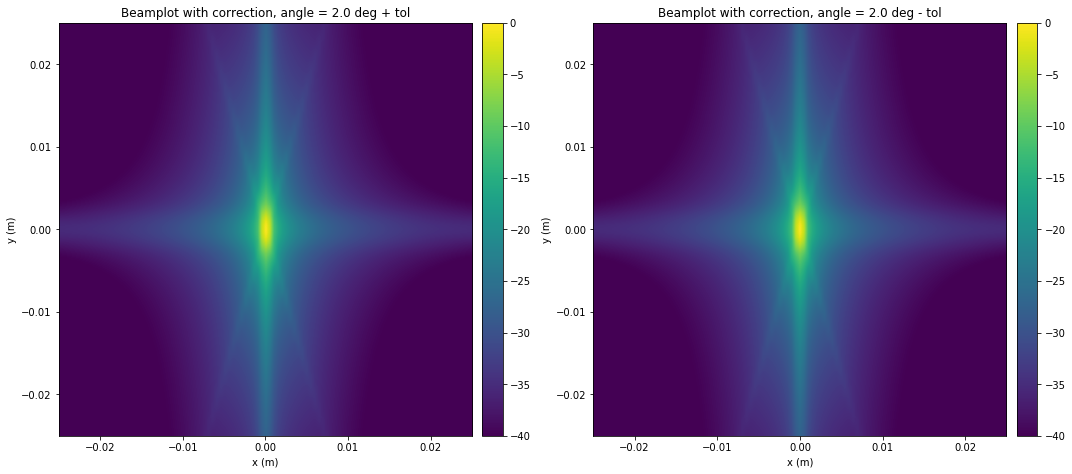

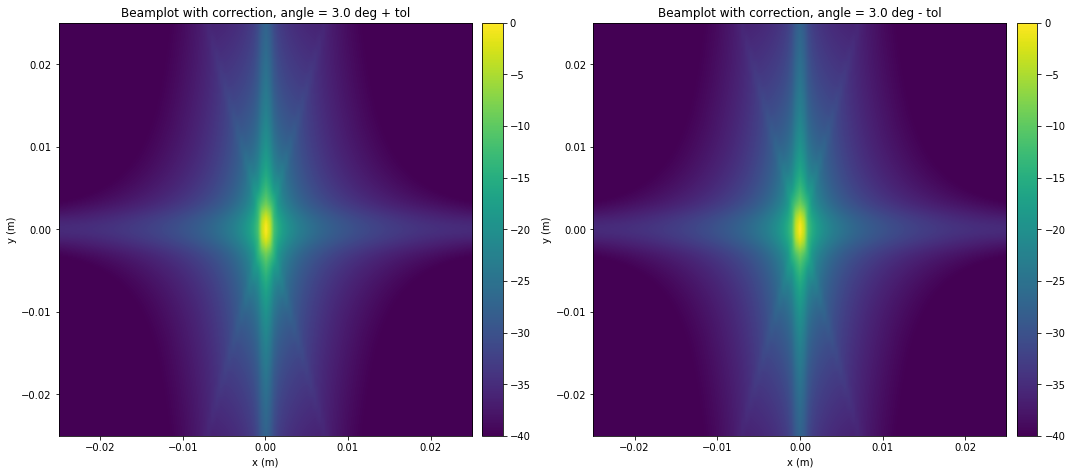

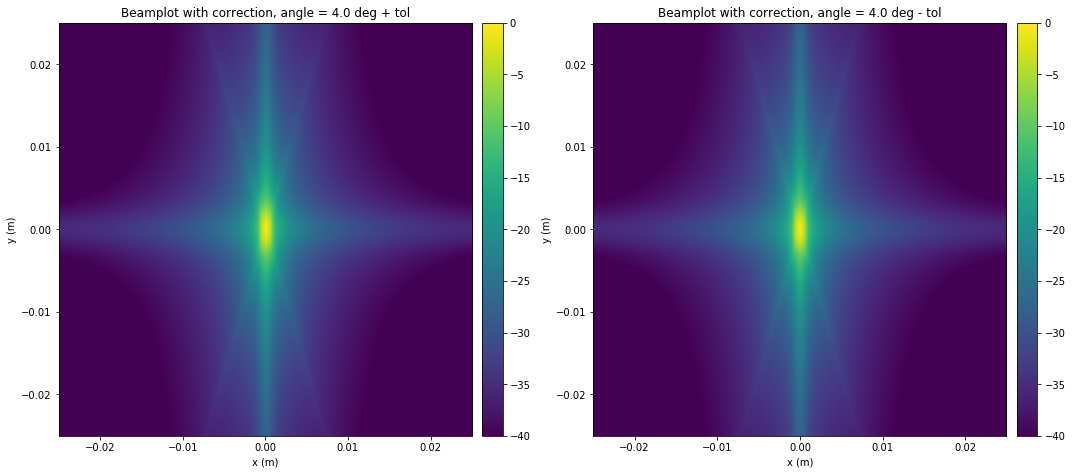

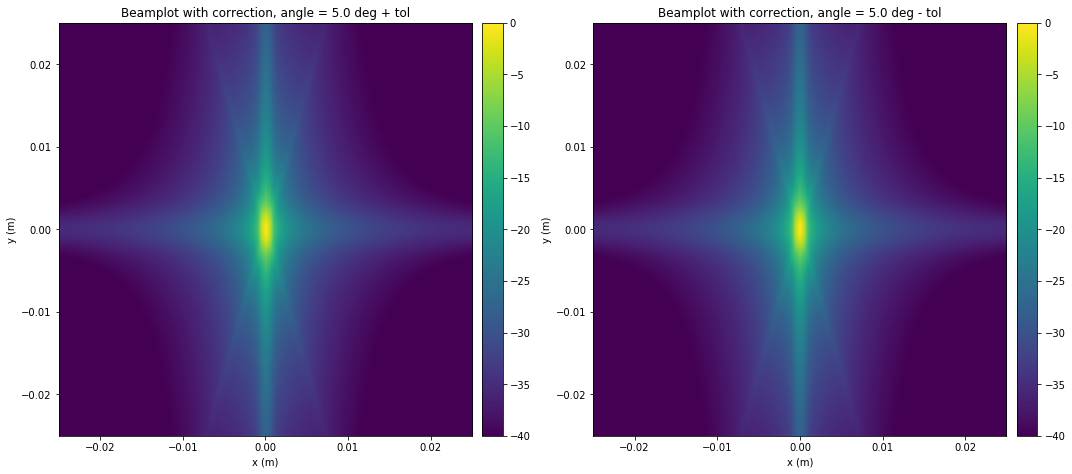

In [3]:
def plot(a):
    
    idx = np.argmin(np.abs(a - angles))
    
    fig = plt.figure(figsize=(15, 9))
    gs = GridSpec(1,2)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    
    extents = (np.min(x), np.max(x)), (np.min(y), np.max(y)), (np.min(z), np.max(z))
    shapes = plus_brightness.shape[1:4]
    extent = list()
    dims = list()
    for i in range(3):
        if shapes[i] != 1:
            extent += extents[i]
            dims.append(('x', 'y', 'z')[i])
    
    bright1 = 20 * np.log10(plus_brightness[idx, ...].squeeze().T / np.max(plus_brightness[idx, ...]))
    bright1[bright1 < -dynamic_range] = -dynamic_range
    bright2= 20 * np.log10(minus_brightness[idx, ...].squeeze().T / np.max(minus_brightness[idx, ...]))
    bright2[bright2 < -dynamic_range] = -dynamic_range
    
    im1 = ax1.imshow(bright1, origin='lower', extent=extent, vmin=-dynamic_range, vmax=0, 
                     interpolation=interpolation, cmap=cmap)
    im2 = ax2.imshow(bright2, origin='lower', extent=extent, vmin=-dynamic_range, vmax=0, 
                     interpolation=interpolation, cmap=cmap)
    
    add_colorbar(im1)
    add_colorbar(im2)
    
    ax1.set_title('Beamplot with correction, angle = ' + str(a) + ' deg + tol')
    ax1.set_xlabel(dims[0] + ' (m)')
    ax1.set_ylabel(dims[1] + ' (m)')
    ax2.set_title('Beamplot with correction, angle = ' + str(a) + ' deg - tol')
    ax2.set_xlabel(dims[0] + ' (m)')
    ax2.set_ylabel(dims[1] + ' (m)')
    
    plt.tight_layout()
    
    return fig

figs = list()
for a in angles:
    figs.append(plot(a))

display(export_widget(figs))